# Problem statement and Objectives

The Indian Premier League (IPL) is one of the most popular cricket leagues globally, attracting millions of fans and generating substantial interest in match predictions. However, accurately predicting the outcome of a match is challenging due to the dynamic nature of the game and the influence of various factors such as team composition, player performance, batting and bowling strengths, and match conditions.

This project aims to address this challenge by developing a machine learning model that predicts the win probability of the chasing team on critical features like batting scores, Current run rate, Required run rate etc. The model will be integrated into an interactive Streamlit web application, allowing users to input match-specific data and receive real-time predictions of win probabilities. This solution aims to provide fans with a deeper understanding of the game, enhance engagement, and potentially offer insights to analysts and enthusiasts interested in the statistical aspects of cricket.




In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import pickle



In [2]:
# importing dataset

matches=pd.read_csv('matches.csv')
deliveries=pd.read_csv('deliveries.csv')

In [3]:
matches.head(5)

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [4]:
deliveries.head(5)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


## Data Preprocessing

In [5]:
# finding total runs of first innings per match
total_score_df=deliveries.groupby(['match_id','inning'])['total_runs'].sum().reset_index()
total_score_df=total_score_df[total_score_df['inning']==1]

In [6]:

total_score_df=total_score_df.reset_index()
total_score_df.head()

,index,match_id,inning,total_runs
0,0,1,1,207
1,2,2,1,184
2,4,3,1,183
3,6,4,1,163
4,8,5,1,157


In [7]:
total_score_df.drop(columns='index',inplace=True)
total_score_df.head()

,match_id,inning,total_runs
0,1,1,207
1,2,1,184
2,3,1,183
3,4,1,163
4,5,1,157


In [8]:
# merging total_score_df to match
match_df=matches.merge(total_score_df[['match_id','total_runs']],left_on='id',right_on='match_id')

In [9]:
match_df.head()

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,match_id,total_runs
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,207
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,2,184
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN,3,183
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN,4,163
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN,5,157


In [10]:
# now there are many teams that no longer play in ipl. so removing them in following few cells
match_df['team1'].unique()

array(['Sunrisers Hyderabad', 'Mumbai Indians', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Delhi Daredevils', 'Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Rising Pune Supergiants',
       'Delhi Capitals'], dtype=object)

In [11]:
teams = [
    'Sunrisers Hyderabad',
    'Mumbai Indians',
    'Royal Challengers Bangalore',
    'Kolkata Knight Riders',
    'Kings XI Punjab',
    'Chennai Super Kings',
    'Rajasthan Royals',
    'Delhi Capitals'
]

In [12]:
match_df['team1'] = match_df['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
match_df['team2'] = match_df['team2'].str.replace('Delhi Daredevils','Delhi Capitals')

match_df['team1'] = match_df['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match_df['team2'] = match_df['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]

In [13]:
match_df.shape

(641, 20)

In [14]:
# now keeping the data of only those matches which was not affected by rain
# first lets check how many matches were affected by rain
match_df['dl_applied'].value_counts()

# we see that 15 matches were affected by rain

0    626
1     15
Name: dl_applied, dtype: int64

In [15]:
match_df=match_df[match_df['dl_applied']==0] 

In [16]:
match_df

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,match_id,total_runs
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,207
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Capitals,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN,5,157
6,7,IPL-2017,Mumbai,09-04-2017,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,4,N Rana,Wankhede Stadium,Nitin Menon,CK Nandan,NaN,7,178
7,8,IPL-2017,Indore,10-04-2017,Royal Challengers Bangalore,Kings XI Punjab,Royal Challengers Bangalore,bat,normal,0,Kings XI Punjab,0,8,AR Patel,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN,8,148
9,10,IPL-2017,Mumbai,12-04-2017,Sunrisers Hyderabad,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,4,JJ Bumrah,Wankhede Stadium,Nitin Menon,CK Nandan,NaN,10,158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,11347,IPL-2019,Mumbai,05-05-2019,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,9,HH Pandya,Wankhede Stadium,Nanda Kishore,O Nandan,S Ravi,11347,143
752,11412,IPL-2019,Chennai,07-05-2019,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Mumbai Indians,0,6,AS Yadav,M. A. Chidambaram Stadium,Nigel Llong,Nitin Menon,Ian Gould,11412,136
753,11413,IPL-2019,Visakhapatnam,08-05-2019,Sunrisers Hyderabad,Delhi Capitals,Delhi Capitals,field,normal,0,Delhi Capitals,0,2,RR Pant,ACA-VDCA Stadium,NaN,NaN,NaN,11413,171
754,11414,IPL-2019,Visakhapatnam,10-05-2019,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,6,F du Plessis,ACA-VDCA Stadium,Sundaram Ravi,Bruce Oxenford,Chettithody Shamshuddin,11414,155


In [17]:
# majority of the useful features are in deliveries df, so we'll take useful columns from match df and join it with deliveries df
match_df=match_df[['match_id','city','winner','total_runs']]
delivery_df=match_df.merge(deliveries,on='match_id')

In [18]:
# we need data of only innings 2, because our final app will take data of innings 2 and predict the probability
delivery_df=delivery_df[delivery_df['inning']==2]
delivery_df

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,0,0,0,1,0,1,NaN,NaN,NaN
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,0,0,0,2,0,2,NaN,NaN,NaN
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,0,0,0,4,0,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,0,0,0,1,0,1,NaN,NaN,NaN
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,0,0,0,2,0,2,NaN,NaN,NaN
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,0,0,0,1,0,1,SR Watson,run out,KH Pandya
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,0,0,0,2,0,2,NaN,NaN,NaN


## Exploratoy Data Analysis

In [19]:
# checking info
delivery_df.info()

# we see that player_dismissed, dismissal kind and fielder columns have too many null values. 
# We'll not use this column as it is. will need to do some feature engineering with these columns or eliminate them

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72413 entries, 125 to 149577
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   match_id          72413 non-null  int64 
 1   city              71581 non-null  object
 2   winner            72386 non-null  object
 3   total_runs_x      72413 non-null  int64 
 4   inning            72413 non-null  int64 
 5   batting_team      72413 non-null  object
 6   bowling_team      72413 non-null  object
 7   over              72413 non-null  int64 
 8   ball              72413 non-null  int64 
 9   batsman           72413 non-null  object
 10  non_striker       72413 non-null  object
 11  bowler            72413 non-null  object
 12  is_super_over     72413 non-null  int64 
 13  wide_runs         72413 non-null  int64 
 14  bye_runs          72413 non-null  int64 
 15  legbye_runs       72413 non-null  int64 
 16  noball_runs       72413 non-null  int64 
 17  penalty_r

In [20]:
# checking description
delivery_df.describe()

# we see that mean and median values are not too different for important columns.
# This shows that there are no outliers
# important columns are the ones which have higher possibility of being used in the training. example- total runs, over etc.
# all the columns of delivery df will not be used in training. some will be eliminated and some new need to be created
# this will be handled later during feature engineering


,match_id,total_runs_x,inning,over,ball,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs_y
count,72413.000000,72413.000000,72413.0,72413.000000,72413.000000,72413.0,72413.000000,72413.000000,72413.000000,72413.000000,72413.000000,72413.000000,72413.000000,72413.000000
mean,2081.518747,165.583956,2.0,9.955726,3.608565,0.0,0.036692,0.005054,0.021267,0.004101,0.000138,1.236214,0.067253,1.303468
std,3724.771739,29.282200,0.0,5.563866,1.806566,0.0,0.245309,0.122473,0.199127,0.074674,0.026277,1.603526,0.344512,1.603395
min,1.000000,65.000000,2.0,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,192.000000,146.000000,2.0,5.000000,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,396.000000,165.000000,2.0,10.000000,4.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,569.000000,185.000000,2.0,15.000000,5.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,11415.000000,250.000000,2.0,20.000000,9.000000,0.0,5.000000,4.000000,5.000000,5.000000,5.000000,7.000000,7.000000,10.000000


In [21]:
delivery_df

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,0,0,0,1,0,1,NaN,NaN,NaN
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,0,0,0,2,0,2,NaN,NaN,NaN
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,0,0,0,4,0,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,0,0,0,1,0,1,NaN,NaN,NaN
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,0,0,0,2,0,2,NaN,NaN,NaN
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,0,0,0,1,0,1,SR Watson,run out,KH Pandya
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,0,0,0,2,0,2,NaN,NaN,NaN


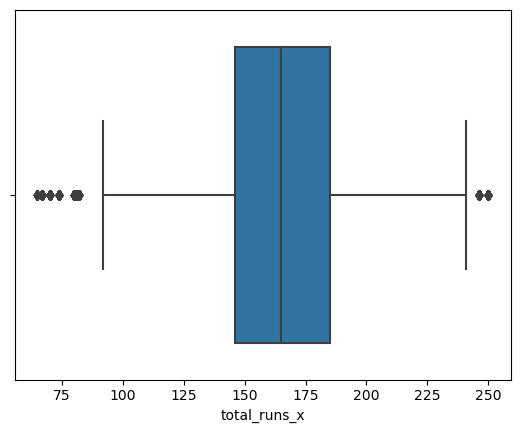

In [22]:
# from the above we got the idea that there is not much outliers
# however drawing a series of boxplots for different important columns to be sure

sns.boxplot(data=delivery_df,x='total_runs_x')
plt.show()

# we see that total runs x has some outliers.
# we'll not use this column as it is. we'll do some feature engineering here


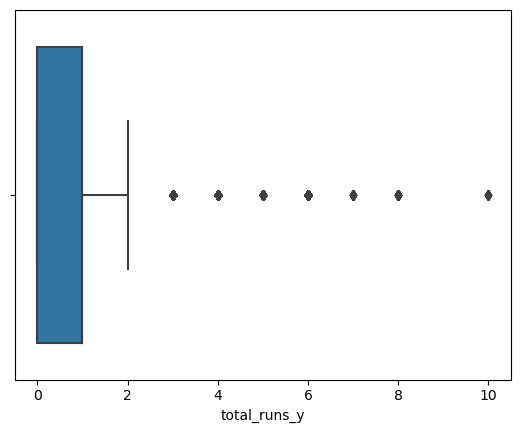

In [23]:
sns.boxplot(data=delivery_df,x='total_runs_y')
plt.show()

# we see that the total_runs_y has too many outliers. 
# we'll not use this column as it is. we'll do some feature engineering

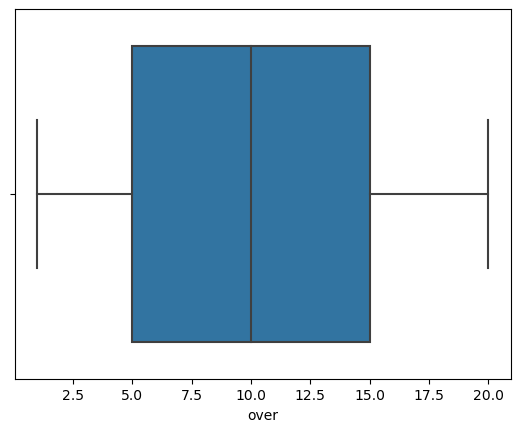

In [24]:
sns.boxplot(data=delivery_df,x='over')
plt.show()

# this looks fine


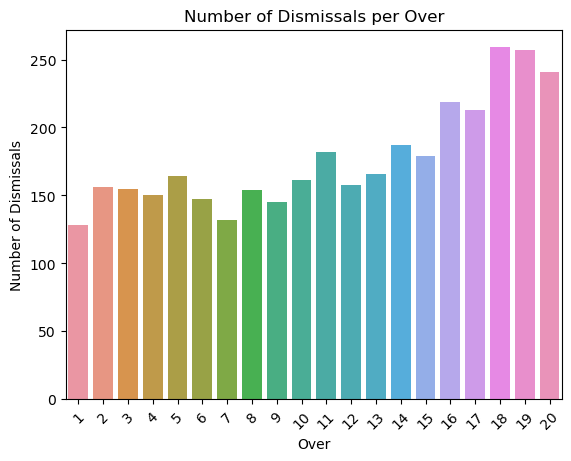

In [25]:
# doing some calculations and drawing barplot of overs and dismissals

dismissals = delivery_df.dropna(subset=['player_dismissed'])

# Counting the number of dismissals in each over
dismissals_per_over = dismissals['over'].value_counts().sort_index()

# Creat inga bar plot
sns.barplot(x=dismissals_per_over.index, y=dismissals_per_over.values)
plt.xlabel('Over')
plt.ylabel('Number of Dismissals')
plt.title('Number of Dismissals per Over')
plt.xticks(rotation=45)
plt.show()


# we see that there is a trend.

## Feature Engineering

In [26]:
# creating a new feture that shows whether the team chasing the target won the match or not
# making a function for this
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

# creating feature

delivery_df['result'] = delivery_df.apply(result,axis=1)

In [27]:
# creating a new feature will show total runs scored till 'n' balls or in other words 'Current score'
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()


In [28]:
# creating a new feature will show total runs left to win
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']+1


In [29]:
# creating a new feature which shows balls left
delivery_df['balls_left']=(20*6)-(delivery_df['over']*6 + delivery_df['ball'])

In [30]:
# creating a new feature which shows wickets left
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x: "1" if x != "0" else "0").astype('int')

wickets = delivery_df.groupby('match_id')['player_dismissed'].cumsum().values
delivery_df['wickets'] = 10 - wickets

delivery_df.head()


,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,result,current_score,runs_left,balls_left,wickets
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,1,0,NaN,NaN,0,1,207,113,10
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,NaN,NaN,0,1,207,112,10
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,NaN,NaN,0,1,207,111,10
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,2,0,NaN,NaN,0,3,205,110,10
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,4,0,NaN,NaN,0,7,201,109,10


In [31]:
# creating a new feature that shows current run rate
# crr=runs/overs
delivery_df['crr'] = (delivery_df['current_score']*6)/(120 - delivery_df['balls_left'])

In [32]:
# creating a new feature that shows required run rate
delivery_df['rrr'] = (delivery_df['runs_left']*6)/delivery_df['balls_left']

In [33]:
# now keeping only required columns in delivery_df
final_df = delivery_df[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr','result']]

In [34]:
final_df

,batting_team,bowling_team,city,runs_left,balls_left,wickets,total_runs_x,crr,rrr,result
125,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,207,113,10,207,0.857143,10.991150,0
126,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,207,112,10,207,0.750000,11.089286,0
127,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,207,111,10,207,0.666667,11.189189,0
128,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,205,110,10,207,1.800000,11.181818,0
129,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,201,109,10,207,3.818182,11.064220,0
...,...,...,...,...,...,...,...,...,...,...
149573,Chennai Super Kings,Mumbai Indians,Hyderabad,1,-2,5,152,7.475410,-3.000000,0
149574,Chennai Super Kings,Mumbai Indians,Hyderabad,-1,-3,5,152,7.512195,2.000000,0
149575,Chennai Super Kings,Mumbai Indians,Hyderabad,-2,-4,4,152,7.500000,3.000000,0
149576,Chennai Super Kings,Mumbai Indians,Hyderabad,-4,-5,4,152,7.536000,4.800000,0


In [35]:
# now the data we have is in order. the balls of a particular over and its related data are in order. 
# This might develop some bias . so shuffling the data
final_df = final_df.sample(final_df.shape[0])

In [36]:
# checking info of our final df
final_df.info()

# we see that rrr column has some null values so dropping those
final_df.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72413 entries, 888 to 104781
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   batting_team  72413 non-null  object 
 1   bowling_team  72413 non-null  object 
 2   city          71581 non-null  object 
 3   runs_left     72413 non-null  int64  
 4   balls_left    72413 non-null  int64  
 5   wickets       72413 non-null  int32  
 6   total_runs_x  72413 non-null  int64  
 7   crr           72413 non-null  float64
 8   rrr           72407 non-null  float64
 9   result        72413 non-null  int64  
dtypes: float64(2), int32(1), int64(4), object(3)
memory usage: 5.8+ MB


In [37]:
# removing rows where final balls left=0 , because it doesn't provide meaningful info to the model
# it also makes required run rate as infinite 
final_df=final_df[final_df['balls_left'] != 0]

In [38]:
final_df.isnull().sum()

batting_team    0
bowling_team    0
city            0
runs_left       0
balls_left      0
wickets         0
total_runs_x    0
crr             0
rrr             0
result          0
dtype: int64

In [39]:
final_df.describe()

,runs_left,balls_left,wickets,total_runs_x,crr,rrr,result
count,71171.000000,71171.000000,71171.000000,71171.000000,71171.000000,71171.000000,71171.000000
mean,93.785840,56.995237,7.557797,165.726546,6.375975,10.800114,0.525959
std,49.892224,33.218616,2.124749,29.308485,2.082590,25.000445,0.499329
min,-15.000000,-8.000000,0.000000,65.000000,0.000000,-702.000000,0.000000
25%,54.000000,29.000000,6.000000,147.000000,5.318182,7.883721,0.000000
50%,93.000000,58.000000,8.000000,165.000000,6.600000,9.825000,1.000000
75%,131.000000,86.000000,9.000000,185.000000,7.735537,12.448180,1.000000
max,250.000000,113.000000,10.000000,250.000000,15.000000,708.000000,1.000000


## Building model

In [40]:
# train test split
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [41]:
# encoding categorical columns and scaling the data
trf = ColumnTransformer([
    ('trf', OneHotEncoder(sparse_output=False, drop='first'), ['batting_team', 'bowling_team', 'city']),
    (('num', StandardScaler(), ['runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr']))
],
remainder='passthrough',  
force_int_remainder_cols=False  
)

#### Logistic regression

In [42]:
# building pipline
pipe_lr = Pipeline(steps=[
    ('step1',trf),
    ('step2',LogisticRegression(solver='liblinear'))
])

In [43]:
# training the model
pipe_lr.fit(X_train,y_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city']),
                                                 ('num', StandardScaler(),
                                                  ['runs_left', 'balls_left',
                                                   'wickets', 'total_runs_x',
                                                   'crr', 'rrr'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

In [44]:
# prediction and accuracy score
y_pred = pipe_lr.predict(X_test)
accuracy_score(y_test,y_pred)

0.8076571829996487

In [45]:
# win probability
pipe_lr.predict_proba(X_test)[0]

array([0.18617584, 0.81382416])

#### naive bayes

In [46]:
# training the model

pipe_nb = Pipeline(steps=[
    ('step1', trf),  
    ('step2', GaussianNB())  
])

pipe_nb.fit(X_train, y_train)



Pipeline(steps=[('step1',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city']),
                                                 ('num', StandardScaler(),
                                                  ['runs_left', 'balls_left',
                                                   'wickets', 'total_runs_x',
                                                   'crr', 'rrr'])])),
                ('step2', GaussianNB())])

In [47]:
# predicting the results and checking accuracy results

y_pred = pipe_nb.predict(X_test)
accuracy_score(y_test,y_pred)


0.7160519845451352

In [48]:
# win probability

pipe_nb.predict_proba(X_test)[0]

array([0.02429821, 0.97570179])

#### K nearest neighbours

In [49]:
# Training the model

pipe_knn = Pipeline(steps=[
    ('trf', trf),
    ('classifier', KNeighborsClassifier(n_neighbors=5))  # You can adjust 'n_neighbors' as needed
])

pipe_knn.fit(X_train,y_train)


Pipeline(steps=[('trf',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city']),
                                                 ('num', StandardScaler(),
                                                  ['runs_left', 'balls_left',
                                                   'wickets', 'total_runs_x',
                                                   'crr', 'rrr'])])),
                ('classifier', KNeighborsClassifier())])

####

In [50]:
# predicting the results and checking accuracy results

y_pred = pipe_knn.predict(X_test)
accuracy_score(y_test,y_pred)

0.9925535651563049

In [51]:
# win probability

pipe_knn.predict_proba(X_test)[0]

array([0., 1.])

## Ensemble algorithms

#### Random forest

In [52]:
# encoding categorical columns
trf_rf = ColumnTransformer([
    ('trf', OneHotEncoder(sparse_output=False, drop='first'), ['batting_team', 'bowling_team', 'city']),
],
remainder='passthrough',  # Pass through the remainder of columns
force_int_remainder_cols=False  # Opt into future behavior to avoid the warning
)

In [53]:
# Training the model

pipe_rf = Pipeline(steps=[
    ('trf', trf_rf),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('trf',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [54]:
# predicting the results and checking accuracy results

y_pred = pipe_rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9993677555321391

In [55]:
# win probability

pipe_rf.predict_proba(X_test)[0]

array([0.01, 0.99])

#### Gradient Boosting

In [56]:
# Training the model

pipe_gbm = Pipeline(steps=[
    ('trf', trf),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
])

pipe_gbm.fit(X_train,y_train)


Pipeline(steps=[('trf',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city']),
                                                 ('num', StandardScaler(),
                                                  ['runs_left', 'balls_left',
                                                   'wickets', 'total_runs_x',
                                                   'crr', 'rrr'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [57]:
# predicting the results and checking accuracy results

y_pred = pipe_gbm.predict(X_test)
accuracy_score(y_test,y_pred)

0.8445381102915349

In [58]:
# win probability

pipe_gbm.predict_proba(X_test)[0]

array([0.23894021, 0.76105979])

#### Xtreme gradient boosting

In [59]:
# training the model

pipe_xgb = Pipeline(steps=[
    ('trf', trf),
    ('classifier', XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, eval_metric='logloss'))
])

pipe_xgb.fit(X_train,y_train)

Pipeline(steps=[('trf',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city']),
                                                 ('num', StandardScaler(),
                                                  ['runs_left', 'balls_left',
                                                   'wickets', 'total_runs_x',
                                                   'crr', 'rrr'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=N...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [60]:
# predicting the results and checking accuracy results

y_pred = pipe_xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.9524411661397962

In [61]:
# win probability

pipe_rf.predict_proba(X_test)[0]

array([0.01, 0.99])

## Hyperparameter tuning
Though random forest and xtreme gradient boosting are giving very good results, their result in probabilities seems to be unrealistic for practical purposes.
Therefore we'll take either gradient boosting algorithm or logistic regression for building the app. We'll first do hyperparameter tuning for both these algorithms.

##### Hyperparameter tuning of Logistic regression


In [66]:

param_grid = {
    'step2__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'step2__penalty': ['l1', 'l2'],  # Regularization type 
}


grid_search_lr = GridSearchCV(estimator=pipe_lr,
                           param_grid=param_grid,
                           cv=5,  
                           scoring='accuracy', 
                           verbose=2,
                           n_jobs=-1)  



In [68]:
# training 
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('step1',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('trf',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['batting_team',
                                                                          'bowling_team',
                                                                          'city']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['runs_left',
                                                                          'balls_left',
                                                                          'wickets',
                                                                          'total_runs_x',
                                                                          'crr',
                                                                          'rrr'])])),
                                       ('step2',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'step2__C': [0.01, 0.1, 1, 10, 100],
                         'step2__penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=2)

In [69]:
# predicting the results and checking accuracy results

y_pred = grid_search_lr.predict(X_test)
accuracy_score(y_test,y_pred)

# we see that hyperparameter tuning not making much difference

0.8075869336143309

In [75]:
# win probability

grid_search_lr.predict_proba(X_test)[0]

array([0.18488206, 0.81511794])

##### Hyperparameter tuning of gradient boosting

In [72]:

param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5],
}


grid_search_gb = GridSearchCV(estimator=pipe_gbm,
                           param_grid=param_grid,
                           cv=5,  
                           scoring='accuracy',
                           verbose=2,
                           n_jobs=-1)





In [73]:
# Training

grid_search_gb.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trf',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('trf',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['batting_team',
                                                                          'bowling_team',
                                                                          'city']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['runs_left',
                                                                          'balls_left',
                                                                          'wickets',
                                                                          'total_runs_x',
                                                                          'crr',
                                                                          'rrr'])])),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.05, 0.1],
                         'classifier__max_depth': [3, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

In [74]:
# predicting the results and checking accuracy results

y_pred = grid_search_gb.predict(X_test)
accuracy_score(y_test,y_pred)



0.9342465753424658

In [76]:
# win probability

grid_search_gb.predict_proba(X_test)[0]

array([0.12779072, 0.87220928])

##### Exporting the tuned gradient boosting model

In [79]:
# Retriving the best estimator
best_model_tuned = grid_search_gb.best_estimator_

In [81]:
# exporting the model
pickle.dump(best_model_tuned, open('best_model_tuned.pkl', 'wb'))
